In [1]:
!pip install efficientnet-pytorch


import numpy as np
import os
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import utils
import torch.nn as nn
import torch.optim as optim
from efficientnet_pytorch import EfficientNet
from PIL import Image
from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn as sns



  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=67233474d2771a3683f67055ffe40cf9982ecf5ca46a436e211d3060b7c78e48
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet-pytorch


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#hyper parameters
batch_size = 32
num_epochs = 12
lr = .001

In [3]:
train_path = '/kaggle/input/deep-lens/dataset/train'
val_path = '/kaggle/input/deep-lens/dataset/val'

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.permute(1, 2, 0)),
#     transforms.CenterCrop(130),
])

In [5]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.samples = self._load_samples()

    def _load_samples(self):
        samples = []
        for cls in self.classes:
            class_path = os.path.join(self.root_dir, cls)
            class_idx = self.class_to_idx[cls]
            for file_name in os.listdir(class_path):
                file_path = os.path.join(class_path, file_name)
                samples.append((file_path, class_idx))
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path, class_idx = self.samples[idx]

        # Load NumPy array
        image = np.load(file_path)
        if self.transform:
            image = self.transform(image)
            
        return image , class_idx

In [6]:
all_dataset = CustomDataset(train_path, transform=transform)
test_dataset = CustomDataset(val_path, transform=transform)


In [7]:
# Split the dataset into training and validation sets
train_indices, val_indices = train_test_split(
    list(range(len(all_dataset))),
    test_size=0.1,
    random_state=42
)


In [8]:
# Create training and validation datasets
train_dataset = torch.utils.data.Subset(all_dataset, train_indices)
val_dataset = torch.utils.data.Subset(all_dataset, val_indices)


In [9]:
print(len(train_dataset),len(val_dataset),len(test_dataset))


27000 3000 7500


In [10]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [11]:
batch_demo = next(iter(test_loader))
batch_demo[0].shape

torch.Size([32, 1, 150, 150])

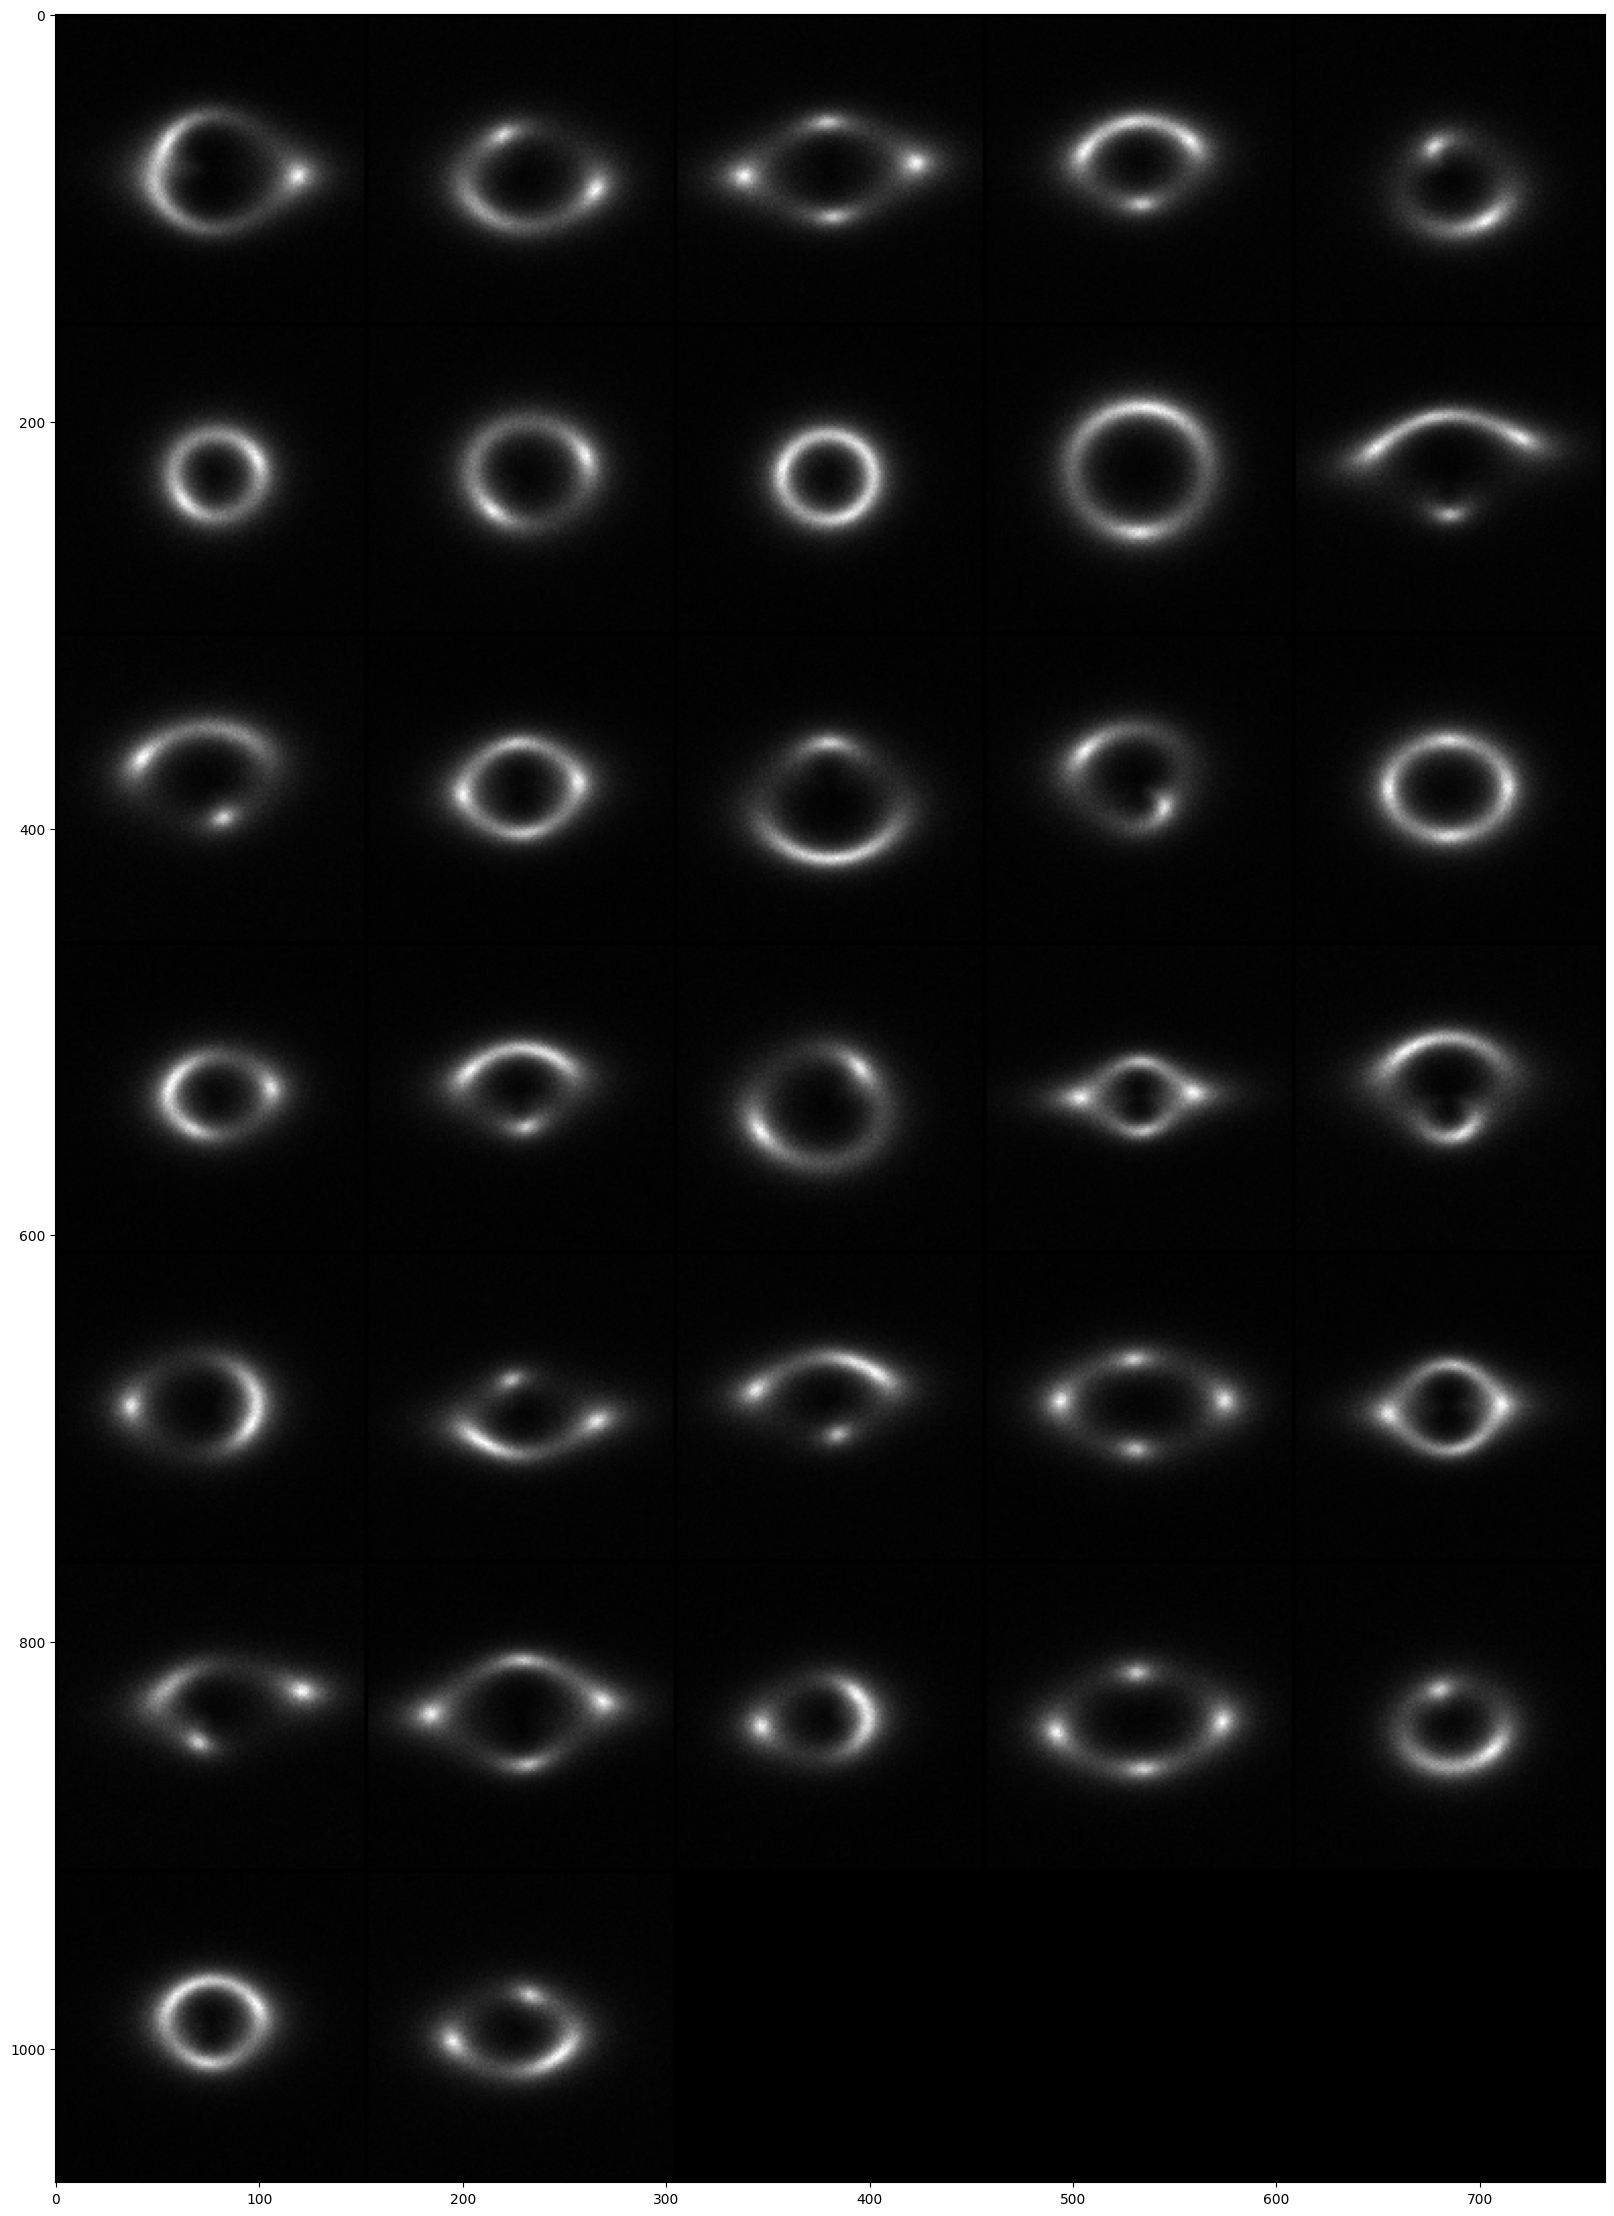

In [12]:
grid = utils.make_grid(batch_demo[0], nrow=5,padding=2, normalize=True)
plt.figure(figsize = (20,70))
plt.imshow(grid.permute(1, 2, 0))

In [13]:
# model_name = 'efficientnet-b0'  
# num_classes = 3

# model = EfficientNet.from_pretrained(model_name, num_classes=num_classes)

# model._conv_stem = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
# model._classifier = nn.Linear(model._fc.in_features, num_classes)

# model = model.to(device)

In [14]:
from efficientnet_pytorch import EfficientNet
import torch.nn as nn

class FineTunedEfficientNet(nn.Module):
    def __init__(self, model, num_classes):
        super(FineTunedEfficientNet, self).__init__()

        self.features = model

        self.features._conv_stem = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)  # Set bias to False

        # fully connected layer with a new sequence of linear layers
        self.features._fc = nn.Sequential(
            nn.Linear(model._fc.in_features, 256),
            nn.PReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(p=0.5),

            # nn.Linear(512, 256),
            # nn.BatchNorm1d(256),
            # nn.PReLU(),
            # nn.Dropout(p=0.5),

            nn.Linear(256, 64),
            nn.PReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(p=0.3),

            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # Forward pass through the modified EfficientNet-B0
        x = self.features(x)

        return x


num_classes = 3
# Load the pre-trained EfficientNet-B0 model
pretrained_model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=3)

# Create an instance of the fine-tuned model
fine_tuned_model = FineTunedEfficientNet(pretrained_model, 3)

# Move the fine-tuned model to the specified device
model = fine_tuned_model.to(device)


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 196MB/s]


Loaded pretrained weights for efficientnet-b0


In [15]:
# model

In [16]:
sample_input = torch.randn((32, 1, 130, 130)).to(device).float()
output = model(sample_input)
print("Output size:", output.size())


Output size: torch.Size([32, 3])


In [17]:
from torch.optim import lr_scheduler


In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [19]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 12

import wandb

# wandb.init(wandb.init(project='deeplens', name='effectnet'))


for epoch in range(num_epochs):
    model.train()
    total_correct_train = 0
    total_samples_train = 0
    running_loss_train = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device).float(), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, predictions_train = torch.max(outputs, 1)
        total_correct_train += (predictions_train == labels).sum().item()
        total_samples_train += labels.size(0)
        running_loss_train += loss.item()

    train_accuracy = total_correct_train / total_samples_train
    train_loss = running_loss_train / len(train_loader)
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)

    # Validation loop
    model.eval()
    with torch.no_grad():
        total_correct_val = 0
        total_samples_val = 0
        running_loss_val = 0.0

        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device).float(), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, predictions_val = torch.max(outputs, 1)
            total_correct_val += (predictions_val == labels).sum().item()
            total_samples_val += labels.size(0)
            running_loss_val += loss.item()

        val_accuracy = total_correct_val / total_samples_val
        val_loss = running_loss_val / len(val_loader)
        val_accuracies.append(val_accuracy)
        val_losses.append(val_loss)
        
        # Log metrics to wandb
#         wandb.log({
#             "Epoch" : epoch,
#             'Train Loss': train_loss,
#             'Train Accuracy': train_accuracy,
#             'Val Loss': val_loss,
#             'Val Accuracy': val_accuracy
#         })
        
        

        print(f'Epoch [{epoch+1}/{num_epochs}],'
              f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
    
    scheduler.step()

# wandb.finish()


Epoch [1/12],Train Loss: 1.1181, Train Accuracy: 0.3580, Val Loss: 2.5116, Val Accuracy: 0.3237
Epoch [2/12],Train Loss: 0.8634, Train Accuracy: 0.5822, Val Loss: 0.7416, Val Accuracy: 0.7170
Epoch [3/12],Train Loss: 0.5294, Train Accuracy: 0.7884, Val Loss: 0.5438, Val Accuracy: 0.7900
Epoch [4/12],Train Loss: 0.3911, Train Accuracy: 0.8545, Val Loss: 0.4534, Val Accuracy: 0.8270
Epoch [5/12],Train Loss: 0.3198, Train Accuracy: 0.8825, Val Loss: 0.3763, Val Accuracy: 0.8443
Epoch [6/12],Train Loss: 0.2717, Train Accuracy: 0.9012, Val Loss: 0.3883, Val Accuracy: 0.8780
Epoch [7/12],Train Loss: 0.2384, Train Accuracy: 0.9146, Val Loss: 0.3747, Val Accuracy: 0.8630
Epoch [8/12],Train Loss: 0.2164, Train Accuracy: 0.9236, Val Loss: 0.2335, Val Accuracy: 0.9207
Epoch [9/12],Train Loss: 0.1962, Train Accuracy: 0.9318, Val Loss: 0.2835, Val Accuracy: 0.9007
Epoch [10/12],Train Loss: 0.1792, Train Accuracy: 0.9360, Val Loss: 0.2888, Val Accuracy: 0.8960
Epoch [11/12],Train Loss: 0.1012, Train

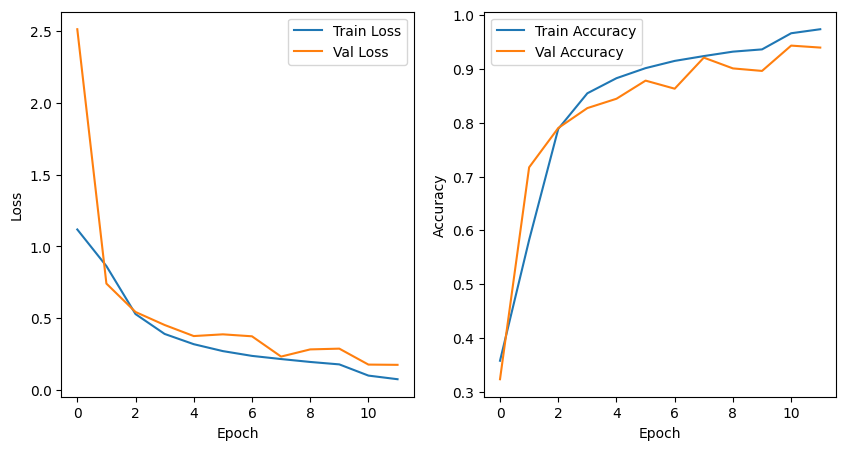

In [20]:
# Plotting training and validation losses
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [24]:
# # Create an instance of your model
# # model =  FineTunedEfficientNet(pretrained_model, num_classes).to(device)

# # Load the saved weights
# model.load_state_dict(torch.load('/kaggle/input/efficient_net_weights/pytorch/weights/1/model_ckassification_weights.pth'))


<All keys matched successfully>

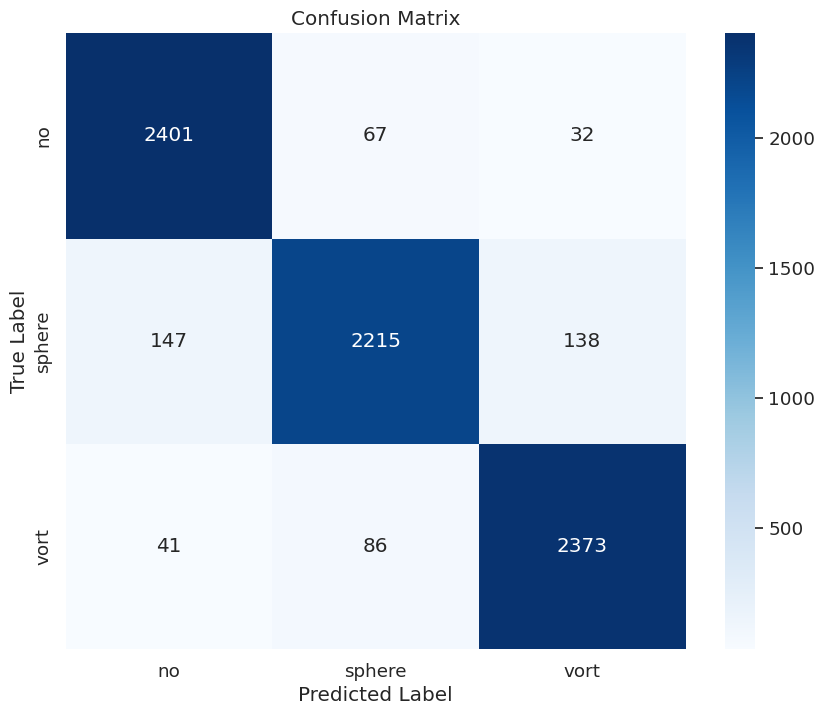

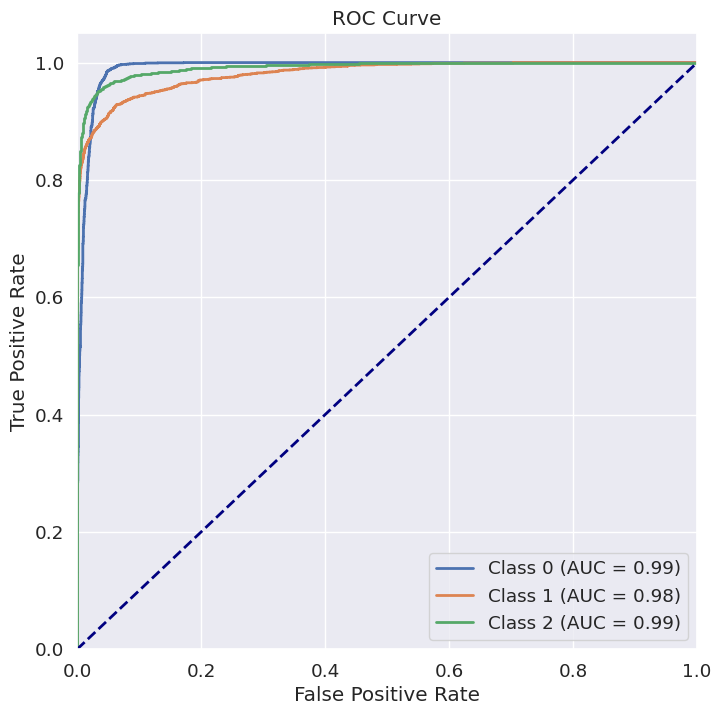

Micro-average AUC Score: 0.9895


In [21]:
import torch
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt

# Assuming you have a test_loader for your test set
model.eval()
all_labels = []
all_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device).float(), labels.to(device)

        outputs = model(inputs)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probabilities.cpu().numpy())

# Convert to NumPy array
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Convert one-hot encoded labels to integer labels
# all_labels = np.argmax(all_labels, axis=0)

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, np.argmax(all_probs, axis=1))
# Plot Confusion Matrix Heatmap
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)  # Adjust font size for better visualization
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_loader.dataset.classes, 
            yticklabels=test_loader.dataset.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ROC Curve and AUC Score
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(test_loader.dataset.classes)):
    fpr[i], tpr[i], _ = roc_curve((all_labels == i).astype(int), all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curve
plt.figure(figsize=(8, 8))
for i in range(len(test_loader.dataset.classes)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Micro-average ROC curve and AUC score
fpr_micro, tpr_micro, _ = roc_curve(np.eye(len(test_loader.dataset.classes))[all_labels].ravel(), all_probs.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

print(f'Micro-average AUC Score: {roc_auc_micro:.4f}')


In [22]:
torch.save(model.state_dict(), 'classification_model.pth')